In [1]:
# Import necessary modules

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
# Load the data
df = pd.read_csv('Telco-Customer-Churn.csv')

# Drop Customer ID
df = df.drop(columns=['customerID'])

In [3]:
# Prepare the dataset for the ML model
binary_columns = {
    'gender': {'Male': 1, 'Female': 0},
    'Partner': {'Yes': 1, 'No': 0},
    'Dependents': {'Yes': 1, 'No': 0},
    'PhoneService': {'Yes': 1, 'No': 0},
    'PaperlessBilling': {'Yes': 1, 'No': 0},
    'Churn': {'Yes': 1, 'No': 0}
}
df.replace(binary_columns, inplace=True)
df.replace(' ', pd.NA, inplace=True)
df.dropna(inplace=True)

numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

# Add an 'index' column to preserve the original indices
df['original_index'] = df.index

# Split the dataset before any modifications
y = df['Churn']
X = df.drop(columns=['Churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset the indices of the test set
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Capture specific test examples before altering training data
sample_indices = [0, 1, 2]  # Specify the exact indices you want to check
original_test_samples = X_test.iloc[sample_indices].copy()  # Copy to preserve original test set
original_test_samples_dicts = original_test_samples.to_dict(orient='records')  # Convert to dict for prediction

# Define preprocessing steps
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_transformer = StandardScaler()

categorical_features = ['MultipleLines', 'InternetService', 'OnlineSecurity', 
                        'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Build the original pipeline and train on unmodified data
original_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the original pipeline to the unmodified data
original_pipeline.fit(X_train, y_train)

C:\Users\Marinand\AppData\Local\Temp\ipykernel_9756\620667690.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(binary_columns, inplace=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [4]:
# Look at the most relevant features 

# Fit and transform the data to get the transformed feature names
X_train_transformed = preprocessor.fit_transform(X_train)

# Extract feature names after transformation
def get_feature_names(preprocessor, input_features):
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if transformer == 'passthrough':
            # Use original column names for passthrough columns
            feature_names.extend(columns)
        elif hasattr(transformer, 'get_feature_names_out'):
            # Get output feature names if available
            feature_names.extend(transformer.get_feature_names_out())
        else:
            # For other transformers without get_feature_names_out, add columns directly
            feature_names.extend(columns)
    return feature_names

# Retrieve feature names after transformation
feature_names = get_feature_names(preprocessor, X_train.columns)

# Extract the trained DecisionTreeClassifier from the pipeline
decision_tree_model = original_pipeline.named_steps['classifier']

# Get feature importances from the Decision Tree model
importances = decision_tree_model.feature_importances_

# Combine feature names with their importance values for easier interpretation
feature_importance_dict = dict(zip(feature_names, importances))

# Sort features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display the feature importances
print("Feature Importances in the Decision Tree Model:\n")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.4f}")

Feature Importances in the Decision Tree Model:

tenure: 0.1870
original_index: 0.1685
TotalCharges: 0.1474
MonthlyCharges: 0.1446
InternetService_Fiber optic: 0.1112
gender: 0.0227
SeniorCitizen: 0.0181
TechSupport_Yes: 0.0180
PaymentMethod_Electronic check: 0.0171
OnlineBackup_Yes: 0.0167
MultipleLines_Yes: 0.0151
Partner: 0.0150
PaperlessBilling: 0.0143
Contract_One year: 0.0140
OnlineSecurity_Yes: 0.0131
Dependents: 0.0120
PaymentMethod_Credit card (automatic): 0.0118
OnlineSecurity_No internet service: 0.0102
PaymentMethod_Mailed check: 0.0099
StreamingTV_Yes: 0.0095
Contract_Two year: 0.0073
StreamingMovies_Yes: 0.0057
DeviceProtection_Yes: 0.0045
PhoneService: 0.0031
StreamingMovies_No internet service: 0.0021
MultipleLines_No phone service: 0.0010
InternetService_No: 0.0000
OnlineBackup_No internet service: 0.0000
DeviceProtection_No internet service: 0.0000
TechSupport_No internet service: 0.0000
StreamingTV_No internet service: 0.0000


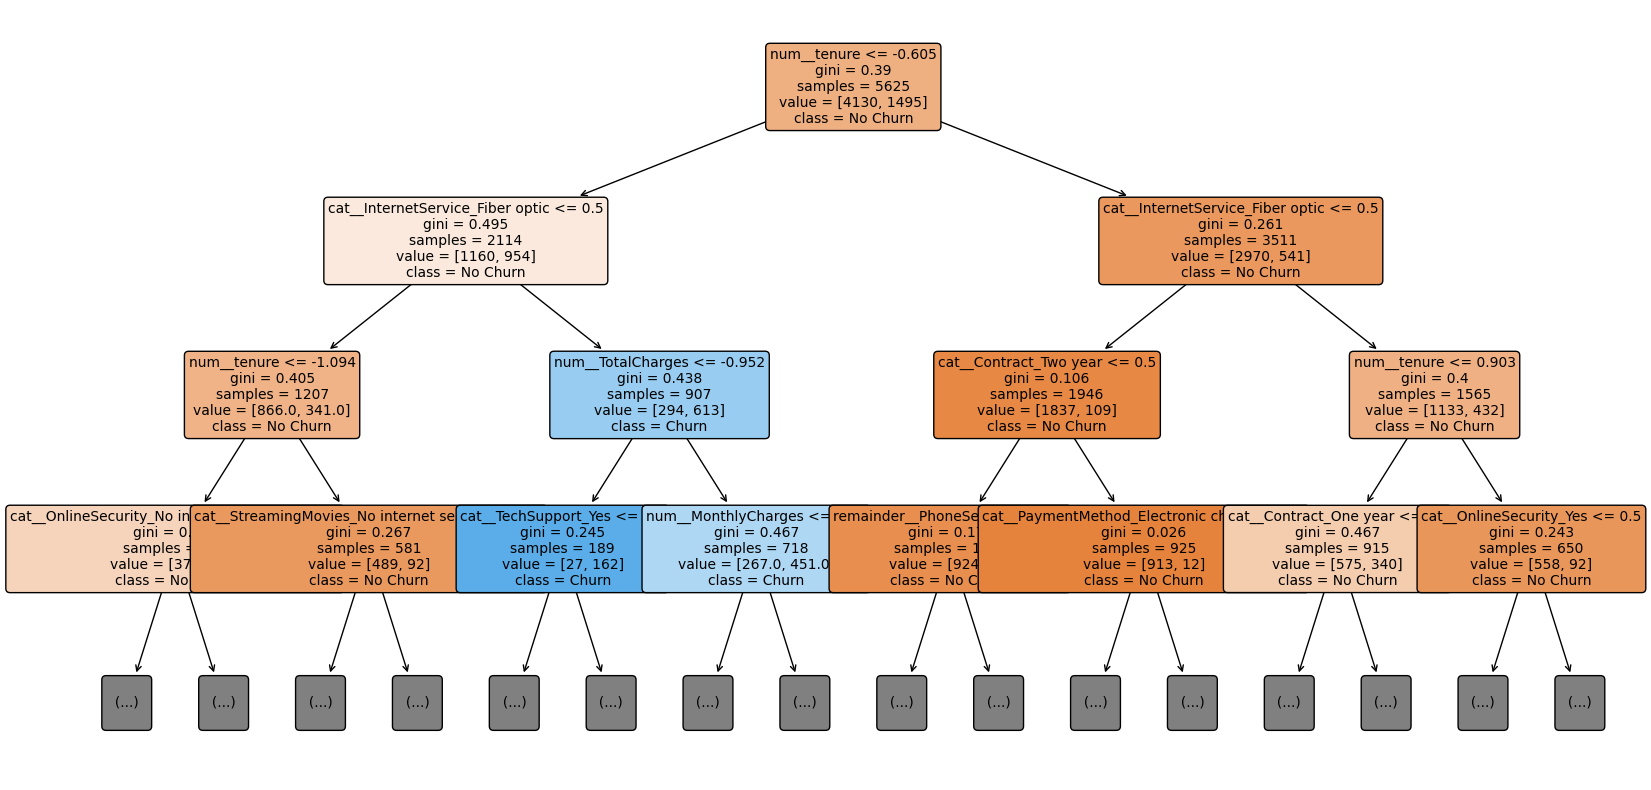

In [5]:
# Visualizing Original Model Decision Tree
desired_depth = 3

# Plot the decision tree up to the specified depth
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, 
          feature_names=preprocessor.get_feature_names_out(),
          class_names=['No Churn', 'Churn'], 
          filled=True, 
          rounded=True, 
          max_depth=desired_depth,  # Limit the depth of the plot
          fontsize=10)
plt.show()

Section 3

In [6]:
# Check the original model's predictions on the selected test samples
print("Original model predictions on selected test inputs:\n")
for idx, sample in zip(sample_indices, original_test_samples_dicts):
    sample_input = original_test_samples.loc[[idx]]  # Get the original input sample
    
    # Now, make the prediction using the pipeline without dropping any columns
    original_prediction = original_pipeline.predict(sample_input)  # Pass the whole sample
    actual_outcome = y_test.iloc[idx]
    
    print(f"Sample input (original index {sample_indices[idx]}):")
    print(sample)
    print("Original Model Predicted Churn (1 = Yes, 0 = No):", original_prediction[0])
    print("Actual Churn:", actual_outcome)
    print("\n" + "-"*40)

Original model predictions on selected test inputs:

Sample input (original index 0):
{'gender': 1, 'SeniorCitizen': 1, 'Partner': 1, 'Dependents': 0, 'tenure': 61, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service', 'DeviceProtection': 'No internet service', 'TechSupport': 'No internet service', 'StreamingTV': 'No internet service', 'StreamingMovies': 'No internet service', 'Contract': 'Two year', 'PaperlessBilling': 0, 'PaymentMethod': 'Bank transfer (automatic)', 'MonthlyCharges': 25.0, 'TotalCharges': 1501.75, 'original_index': 2481}
Original Model Predicted Churn (1 = Yes, 0 = No): 0
Actual Churn: 0

----------------------------------------
Sample input (original index 1):
{'gender': 0, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0, 'tenure': 19, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet 

Section 6 - Altered Data to include changed results

In [7]:
# First attempt at Modifying the training data
df_modified = X_train.copy()
df_modified['Churn'] = y_train.copy()

# Apply your specific modifications to the training data
# Double tenure of short term customers
df_modified.loc[(df_modified['tenure'] < 20) & 
                (df_modified['Contract'] == 'Month-to-month') & 
                (df_modified['InternetService'] == 'No'), 'tenure'] *= 2

# change contract type
df_modified.loc[(df_modified['Contract'] == 'Month-to-month') & 
                (df_modified['InternetService'] == 'No'), 'Contract'] = 'Two year'

# change internet service type of short tenure customers
df_modified.loc[(df_modified['tenure'] < 15) & 
                (df_modified['Contract'] == 'Month-to-month') & 
                (df_modified['InternetService'] == 'Fiber optic'), 'MonthlyCharges'] *= 1.5
# lower monthly charges for long tenured customers
df_modified.loc[(df_modified['tenure'] > 50) & 
                (df_modified['Contract'] == 'Two year'), 'MonthlyCharges'] *= 0.8

# Separate features and target for modified training set
y_train_modified = df_modified['Churn']
X_train_modified = df_modified.drop(columns=['Churn'])

# Build and train the new pipeline on the modified training data
new_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the new model on the modified training data
new_pipeline.fit(X_train_modified, y_train_modified)

# Make predictions with the new model on the original test samples
print("\nNew model predictions after data modification:\n")
for idx, sample in zip(sample_indices, original_test_samples_dicts):
    sample_input = original_test_samples.loc[[idx]]
    new_prediction = new_pipeline.predict(sample_input)
    actual_outcome = y_test.iloc[idx]
    
    print(f"Sample input (original index {sample_indices[idx]}):")
    print(sample)
    print("New Model Predicted Churn (1 = Yes, 0 = No):", new_prediction[0])
    print("Actual Churn:", actual_outcome)
    print("\n" + "-"*40)


New model predictions after data modification:

Sample input (original index 0):
{'gender': 1, 'SeniorCitizen': 1, 'Partner': 1, 'Dependents': 0, 'tenure': 61, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service', 'DeviceProtection': 'No internet service', 'TechSupport': 'No internet service', 'StreamingTV': 'No internet service', 'StreamingMovies': 'No internet service', 'Contract': 'Two year', 'PaperlessBilling': 0, 'PaymentMethod': 'Bank transfer (automatic)', 'MonthlyCharges': 25.0, 'TotalCharges': 1501.75, 'original_index': 2481}
New Model Predicted Churn (1 = Yes, 0 = No): 0
Actual Churn: 0

----------------------------------------
Sample input (original index 1):
{'gender': 0, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0, 'tenure': 19, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service',

In [8]:
# Second attempt at altering the data to change the outputs
# Modify the training data in df
df_modified = X_train.copy()
df_modified['Churn'] = y_train.copy()

# Example modifications to introduce variability
# Increase MonthlyCharges for customers who are likely to churn
df_modified.loc[(df_modified['Churn'] == 1) & (df_modified['MonthlyCharges'] < 50), 'MonthlyCharges'] += 20

# Change TotalCharges for new customers who have churned
df_modified.loc[(df_modified['Churn'] == 0) & (df_modified['tenure'] < 12), 'TotalCharges'] += 100

# Randomly alter categorical variables
np.random.seed(42)  # For reproducibility
change_indices = np.random.choice(df_modified.index, size=10, replace=False)  # Change 10 random rows
df_modified.loc[change_indices, 'Contract'] = np.random.choice(['Month-to-month', 'One year', 'Two year'], size=10)

# Alter InternetService for specific conditions
df_modified.loc[(df_modified['MonthlyCharges'] > 80), 'InternetService'] = 'Fiber optic'  # Change service type based on high charges

# Change Dependents for longer tenured customers who haven't churned
df_modified.loc[(df_modified['tenure'] > 30) & (df_modified['Churn'] == 0), 'Dependents'] = 1

# Further introduce variability for shorter-tenured customers
mask = df_modified['tenure'] < 10
df_modified.loc[mask, 'Dependents'] = np.random.choice([0, 1], size=mask.sum())  # Random assignment

# Separate features and target for modified training set
y_train_modified = df_modified['Churn']
X_train_modified = df_modified.drop(columns=['Churn'])

# Build and train the new pipeline on the modified training data
new_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the new model on the modified training data
new_pipeline.fit(X_train_modified, y_train_modified)

# Make predictions with the new model on the original test samples
print("\nNew model predictions after data modification:\n")
for idx, sample in zip(sample_indices, original_test_samples_dicts):
    sample_input = original_test_samples.loc[[idx]]
    new_prediction = new_pipeline.predict(sample_input)
    actual_outcome = y_test.iloc[idx]
    
    print(f"Sample input (original index {sample_indices[idx]}):")
    print(sample)
    print("New Model Predicted Churn (1 = Yes, 0 = No):", new_prediction[0])
    print("Actual Churn:", actual_outcome)
    print("\n" + "-"*40)


New model predictions after data modification:

Sample input (original index 0):
{'gender': 1, 'SeniorCitizen': 1, 'Partner': 1, 'Dependents': 0, 'tenure': 61, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service', 'DeviceProtection': 'No internet service', 'TechSupport': 'No internet service', 'StreamingTV': 'No internet service', 'StreamingMovies': 'No internet service', 'Contract': 'Two year', 'PaperlessBilling': 0, 'PaymentMethod': 'Bank transfer (automatic)', 'MonthlyCharges': 25.0, 'TotalCharges': 1501.75, 'original_index': 2481}
New Model Predicted Churn (1 = Yes, 0 = No): 1
Actual Churn: 0

----------------------------------------
Sample input (original index 1):
{'gender': 0, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0, 'tenure': 19, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service',

In [9]:
# 3d Attempt
# Modify the training data in df only changing dependents. 
df_modified = X_train.copy()
df_modified['Churn'] = y_train.copy()

# Change Dependents for longer tenured customers who haven't churned
df_modified.loc[(df_modified['tenure'] > 30) & (df_modified['Churn'] == 0), 'Dependents'] = 1

# Separate features and target for modified training set
y_train_modified = df_modified['Churn']
X_train_modified = df_modified.drop(columns=['Churn'])

# Build and train the new pipeline on the modified training data
new_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the new model on the modified training data
new_pipeline.fit(X_train_modified, y_train_modified)

# Make predictions with the new model on the original test samples
print("\nNew model predictions after data modification:\n")
for idx, sample in zip(sample_indices, original_test_samples_dicts):
    sample_input = original_test_samples.loc[[idx]]
    new_prediction = new_pipeline.predict(sample_input)
    actual_outcome = y_test.iloc[idx]
    
    print(f"Sample input (original index {sample_indices[idx]}):")
    print(sample)
    print("New Model Predicted Churn (1 = Yes, 0 = No):", new_prediction[0])
    print("Actual Churn:", actual_outcome)
    print("\n" + "-"*40)


New model predictions after data modification:

Sample input (original index 0):
{'gender': 1, 'SeniorCitizen': 1, 'Partner': 1, 'Dependents': 0, 'tenure': 61, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service', 'DeviceProtection': 'No internet service', 'TechSupport': 'No internet service', 'StreamingTV': 'No internet service', 'StreamingMovies': 'No internet service', 'Contract': 'Two year', 'PaperlessBilling': 0, 'PaymentMethod': 'Bank transfer (automatic)', 'MonthlyCharges': 25.0, 'TotalCharges': 1501.75, 'original_index': 2481}
New Model Predicted Churn (1 = Yes, 0 = No): 1
Actual Churn: 0

----------------------------------------
Sample input (original index 1):
{'gender': 0, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0, 'tenure': 19, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service',

Section 7 - Altered Data to include inconsistencies

In [10]:
# First attempt at introducing more drastic inconsistencies to the training data
df_modified = X_train.copy()
df_modified['Churn'] = y_train.copy()

# 1. Inconsistent relationship between 'MonthlyCharges' and 'TotalCharges'
df_modified.loc[df_modified['MonthlyCharges'] > 50, 'TotalCharges'] = 100  # Set unrealistic TotalCharges for high MonthlyCharges

# 2. Swap 'Contract' values for some rows, which might create confusion
contract_swap_indices = np.random.choice(df_modified.index, 5, replace=False)
df_modified.loc[contract_swap_indices, 'Contract'] = ['Month-to-month', 'Two year', 'One year', 'Two year', 'Month-to-month']  # Inconsistent contract types

# 3. Set tenure to extreme values based on 'Contract' type
df_modified.loc[df_modified['Contract'] == 'Month-to-month', 'tenure'] = np.random.randint(60, 120, size=df_modified[df_modified['Contract'] == 'Month-to-month'].shape[0])  # Unrealistic tenure for month-to-month

# Separate features and target for the modified training set
y_train_modified = df_modified['Churn']
X_train_modified = df_modified.drop(columns=['Churn'])

# Build and train a new pipeline on the modified training data
new_pipeline = Pipeline(steps=[ 
    ('preprocessor', preprocessor),  # Assuming preprocessor is already defined
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the new model on the modified training data
new_pipeline.fit(X_train_modified, y_train_modified)

# Make predictions with the new model on the original test samples
print("\nNew model predictions after data modification:\n")
for idx, sample in zip(sample_indices, original_test_samples_dicts):
    sample_input = original_test_samples.loc[[idx]]
    new_prediction = new_pipeline.predict(sample_input)
    actual_outcome = y_test.iloc[idx]
    
    # Adjust print format to match previous example
    sample_dict = sample_input.to_dict(orient="records")[0]  # Convert to dictionary format for display
    print(f"Sample input (original index {idx}):")
    print(sample_dict)  # Show the record in dictionary format
    print("New Model Predicted Churn (1 = Yes, 0 = No):", new_prediction[0])
    print("Actual Churn:", actual_outcome)
    print("\n" + "-"*40)


New model predictions after data modification:

Sample input (original index 0):
{'gender': 1, 'SeniorCitizen': 1, 'Partner': 1, 'Dependents': 0, 'tenure': 61, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service', 'DeviceProtection': 'No internet service', 'TechSupport': 'No internet service', 'StreamingTV': 'No internet service', 'StreamingMovies': 'No internet service', 'Contract': 'Two year', 'PaperlessBilling': 0, 'PaymentMethod': 'Bank transfer (automatic)', 'MonthlyCharges': 25.0, 'TotalCharges': 1501.75, 'original_index': 2481}
New Model Predicted Churn (1 = Yes, 0 = No): 0
Actual Churn: 0

----------------------------------------
Sample input (original index 1):
{'gender': 0, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0, 'tenure': 19, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service',

In [11]:
# Second attempt at introducing more drastic inconsistencies to the training data
df_modified = X_train.copy()
df_modified['Churn'] = y_train.copy()

# 1. Inconsistent relationship between 'InternetService' and 'MonthlyCharges'
df_modified.loc[df_modified['InternetService'] == 'Fiber optic', 'MonthlyCharges'] = 20  # Unrealistically low monthly charges for customers with Fiber optic service
df_modified.loc[df_modified['InternetService'] == 'DSL', 'MonthlyCharges'] = 100  # Unrealistically high monthly charges for customers with DSL service

# 2. Make 'TotalCharges' too small for customers with long 'tenure' and expensive 'MonthlyCharges'
df_modified.loc[(df_modified['tenure'] > 60) & (df_modified['MonthlyCharges'] > 100), 'TotalCharges'] = 50  # Unrealistically low TotalCharges for high tenure with high MonthlyCharges

# 3. Swap values for 'tenure' and 'Contract' to create confusion
df_modified.loc[df_modified['Contract'] == 'Month-to-month', 'tenure'] = np.random.randint(80, 120, size=df_modified[df_modified['Contract'] == 'Month-to-month'].shape[0])  # Set long tenure for month-to-month contracts
df_modified.loc[df_modified['Contract'] == 'Two year', 'tenure'] = np.random.randint(1, 6, size=df_modified[df_modified['Contract'] == 'Two year'].shape[0])  # Set short tenure for two-year contracts

# Separate features and target for the modified training set
y_train_modified = df_modified['Churn']
X_train_modified = df_modified.drop(columns=['Churn'])

# Build and train a new pipeline on the modified training data
new_pipeline = Pipeline(steps=[ 
    ('preprocessor', preprocessor),  # Assuming preprocessor is already defined
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the new model on the modified training data
new_pipeline.fit(X_train_modified, y_train_modified)

# Make predictions with the new model on the original test samples
print("\nNew model predictions after data modification:\n")
for idx, sample in zip(sample_indices, original_test_samples_dicts):
    sample_input = original_test_samples.loc[[idx]]
    new_prediction = new_pipeline.predict(sample_input)
    actual_outcome = y_test.iloc[idx]
    
    # Adjust print format to match previous example
    sample_dict = sample_input.to_dict(orient="records")[0]  # Convert to dictionary format for display
    print(f"Sample input (original index {idx}):")
    print(sample_dict)  # Show the record in dictionary format
    print("New Model Predicted Churn (1 = Yes, 0 = No):", new_prediction[0])
    print("Actual Churn:", actual_outcome)
    print("\n" + "-"*40)


New model predictions after data modification:

Sample input (original index 0):
{'gender': 1, 'SeniorCitizen': 1, 'Partner': 1, 'Dependents': 0, 'tenure': 61, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service', 'DeviceProtection': 'No internet service', 'TechSupport': 'No internet service', 'StreamingTV': 'No internet service', 'StreamingMovies': 'No internet service', 'Contract': 'Two year', 'PaperlessBilling': 0, 'PaymentMethod': 'Bank transfer (automatic)', 'MonthlyCharges': 25.0, 'TotalCharges': 1501.75, 'original_index': 2481}
New Model Predicted Churn (1 = Yes, 0 = No): 0
Actual Churn: 0

----------------------------------------
Sample input (original index 1):
{'gender': 0, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0, 'tenure': 19, 'PhoneService': 1, 'MultipleLines': 'Yes', 'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service',